# Initial analysis

In [ ]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns

### Data preprocessing : Original data

In [ ]:
# Execute dataCleaning.py
# This script create dictionaries of freebase_id, convert date to datetime object, transform our columns

#%run src/scripts/dataCleaning.py

Movies successfully loaded
Characters successfully loaded
Clusters successfully loaded
Summaries successfully loaded
Dates successfully converted
Build of countries dictionnary...
Build of languages dictionnary...
Build of genres dictionnary...
Build of actors dictionnary...
Build of character dictionnary...
Build of movies dictionnary...
Dictionnaries successfully saved
Saved movies_cleaned to data/cleanData/movies_cleaned.csv
Saved characters_cleaned to data/cleanData/characters_cleaned.csv
Saved character_clusters_cleaned to data/cleanData/character_clusters_cleaned.csv
Saved summaries_cleaned to data/cleanData/summaries_cleaned.csv
Datasets successfully saved
Data cleaning successfully done


In [2]:
# Import dataloader function
path = 'src/data'
sys.path.append(path)
from dataLoader import loadDataframe

In [3]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)
df_characters = loadDataframe('characters', path_to_directory)
df_clusters = loadDataframe('clusters', path_to_directory)
df_summaries = loadDataframe('summaries', path_to_directory)

c:\Users\Oscar\Project ADA\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


### Data statistics overview

In [3]:
print(df_movies.info())

NameError: name 'df_movies' is not defined

In [5]:
df_movies.describe()

,wiki_id,revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [ ]:
# Non null values proportion
df_movies.isnull().mean()

wiki_id                  0.000000
freebase_id              0.000000
original_title           0.000000
release_date             0.084437
revenue                  0.897224
runtime                  0.250180
languages                0.000000
countries                0.000000
genres                   0.000000
countries_freebase_id    0.000000
languages_freebase_id    0.000000
genres_freebase_id       0.000000
dtype: float64

The features that we are interested in are the following:
- 'release_date' : more than 80% of the movies have a release date
- 'genre' : 100% of the movies have a genre
- 'countries' : 100% of the movies have a country
- 'languages' : 100% of the movies have a language

So we have a large amount of non null values that we can use to make our analysis. 

In [16]:
from matplotlib_venn import venn2

def intersectionWikiId(df1, df2, name1, name2, id_column='id'):
    # Ids extraction from each DataFrame
    ids1 = set(df1[id_column].unique())
    ids2 = set(df2[id_column].unique())
    
    # Compute intersection and differences
    intersection = ids1 & ids2
    only_df1 = ids1 - ids2
    only_df2 = ids2 - ids1
    
    # Count elements
    count_intersection = len(intersection)
    count_only_df1 = len(only_df1)
    count_only_df2 = len(only_df2)
    total = count_intersection + count_only_df1 + count_only_df2

    # Venn diagram
    venn = venn2(subsets=(1, 1, 1), set_labels=(name1, name2))
    
    # Add counts
    venn.get_label_by_id('10').set_text(f'{count_only_df1}')
    venn.get_label_by_id('01').set_text(f'{count_only_df2}')
    venn.get_label_by_id('11').set_text(f'{count_intersection}')
    
    plt.title("Intersection between " + name1 + " and " + name2)
    plt.show()

ModuleNotFoundError: No module named 'matplotlib_venn'

In [13]:
intersectionWikiId(df_movies, df_characters, 'Movies', 'Characters', id_column='wiki_id')

NameError: name 'intersectionWikiId' is not defined

### Economics

### Culture

Topic modelling

In [ ]:
intersectionWikiId(df_movies, df_summaries, 'Movies', 'Summaries', id_column='wiki_id')

# Theme Study for Cultural Influence Analysis

In [ ]:
import sys
sys.path.append('../scripts')

from scriptculture import process_data_us_influence          # Import the function that processes the data for this study

df_us_influence = process_data_us_influence()
df_us_influence.head()

,Country,US_Term_Count,Number of movies,Influence_score,log_number_of_movies,World_region
0,France,531,2297,0.231171,7.739359,Europe
1,Soviet Union,30,255,0.117647,5.541264,Eastern Europe and Central Asia
2,Russia,18,217,0.082949,5.379897,Eastern Europe and Central Asia
3,United States of America,7657,20789,0.368320,9.942179,North America
4,India,262,4752,0.055135,8.466321,South Asia


For this analysis, we identified a list of typically american words. We then search for this words occurences in the different summaries. We then grouped the results by countries.

The processed dataset that we'll use for this analyse is completed with the features :
 - US_Term_Count : Number of us terms found in the movies from each country
 - Number of movies : number of movies in each country
 - Influence score : ratio of US_Term_Count/Number of movies
 - World_region : Geographical cluster that we identified 


In [ ]:
from importlib import reload
import scriptculture
reload(scriptculture)

<module 'scriptculture' from 'c:\\Users\\Oscar\\Project ADA\\ada-2024-project-teamcsx24\\src\\models\\../scripts\\scriptculture.py'>

In [ ]:
df_us_influence.describe()

,US_Term_Count,Number of movies,ratio,log_number_of_movies
count,147.000000,147.000000,147.000000,147.000000
mean,85.088435,321.510204,0.147156,3.290563
std,639.985937,1797.950894,0.230474,1.925694
min,0.000000,2.000000,0.000000,0.693147
25%,0.000000,6.000000,0.000000,1.791759
50%,2.000000,17.000000,0.090909,2.833213
75%,14.000000,101.000000,0.202210,4.615121
max,7657.000000,20789.000000,2.000000,9.942179


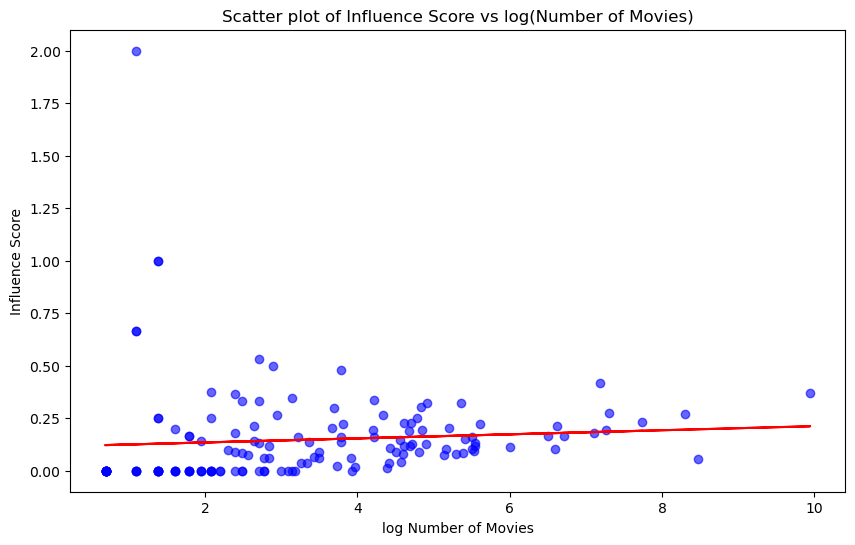

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(
    df_us_influence['log_number_of_movies'], 
    df_us_influence['Influence_score'], 
    color='blue', 
    alpha=0.6
)
#add the linear regression line
z = np.polyfit(df_us_influence['log_number_of_movies'], df_us_influence['Influence_score'], 1)
p = np.poly1d(z)
plt.plot(df_us_influence['log_number_of_movies'],p(df_us_influence['log_number_of_movies']),"r-")
plt.title('Scatter plot of Influence Score vs log(Number of Movies)')
plt.xlabel('log Number of Movies')
plt.ylabel('Influence Score')

plt.show()

Too Many small countries with few films, resulting in a high standard deviation (more than 6 times the average term count) and not relevant linear regression, clustering was necessary. The first clustering that seemed the most logical to us was geographical clustering.


C:\Users\Oscar\AppData\Local\Temp\ipykernel_25812\3488935404.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
C:\Users\Oscar\AppData\Local\Temp\ipykernel_25812\3488935404.py:8: UserWarning: 
The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))


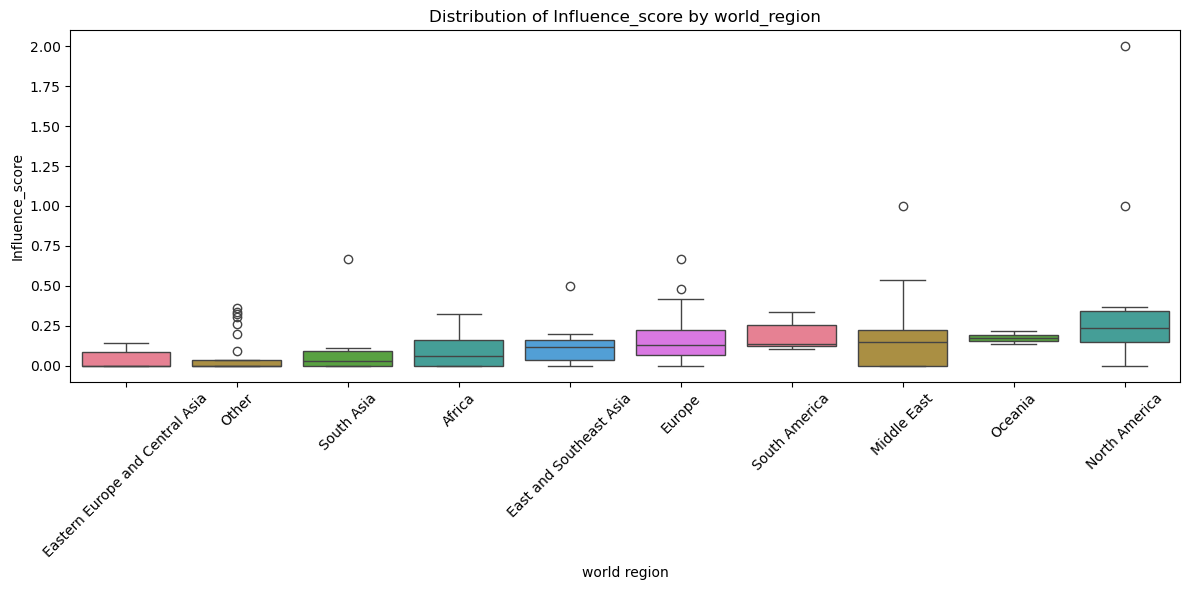

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
# Sort by median ratio
median_order = df_us_influence.groupby('World_region')['Influence_score'].median().sort_values().index

# Create the boxplot with the sorted order
sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
plt.title('Distribution of Influence_score by world_region')
plt.xlabel('world region')
plt.ylabel('Influence_score')


plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [ ]:
df_us_influence.groupby('World_region')['Influence_score'].describe() #Checking the uniformity of the clusters regarding our feature

,count,mean,std,min,25%,50%,75%,max
World_region,,,,,,,,
Africa,17.0,0.087246,0.094800,0.000000,0.000000,0.060606,0.159091,0.323529
East and Southeast Asia,13.0,0.128948,0.128923,0.000000,0.036145,0.113580,0.162602,0.500000
Eastern Europe and Central Asia,9.0,0.038162,0.059185,0.000000,0.000000,0.000000,0.082949,0.142857
Europe,42.0,0.161546,0.148088,0.000000,0.065202,0.127815,0.224474,0.666667
Middle East,11.0,0.209803,0.309140,0.000000,0.000000,0.147368,0.222656,1.000000
North America,10.0,0.448792,0.611118,0.000000,0.148810,0.236722,0.344772,2.000000
Oceania,2.0,0.173358,0.057340,0.132812,0.153085,0.173358,0.193631,0.213904
Other,29.0,0.065831,0.123967,0.000000,0.000000,0.000000,0.035714,0.363636
South America,8.0,0.182935,0.086291,0.101215,0.124561,0.135632,0.253289,0.333333


The geographical clusters are not very uniform (2 countries for Oceania vs 42 for Europe), and not homogeneous regarding the ratio feature. Indeed, we observe a high standard deviation in each country. This cluster is very interesting in term of interpretability but we should consider another clustering method to solve these issues.

Areas for improvement for this study:

 - The identification of US-related terms could be enhanced, either manually or through more advanced techniques. We have begun exploring Natural Language Processing (NLP) methods that could assist with this task and even enable us to assess the influence of each country on others based on the themes present in the film summaries. We started to look at Transformer from HuggingFace and Spacy that could be used for this task

 - The current geographical clustering may not be optimal due to its lack of uniformity and the high variance in the ratios. To address this, we plan to experiment with clustering algorithms like KNN or centroids (as we can define an euclidian distance with the ratio) to achieve more homogeneous,uniform and interpretable clusters.




## NLP methods utilization

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

#Summary example
resume = "The character travels through the streets of Paris, facing challenges that test his courage. He then fly straight to Spain"

# We apply the NLP model to the summary
doc = nlp(resume)

# Extract the geographical entities from the summary
pays_detectes = [ent.text for ent in doc.ents if ent.label_ == "GPE"]  # GPE = Geopolitical Entity

print(pays_detectes)

['Paris', 'Spain']


We will expand our analysis by exploring the influence of specific cities or countries on movie themes. One approach would be to create an additional influence feature based on the frequency of mentions of cities or countries in the movie summaries. This would allow us to quantify the impact of these locations on the themes, potentially revealing patterns of cultural influence or regional trends within the film industry.

In [ ]:
from transformers import pipeline

# Here we use the zero-shot-classification pipeline
nlp = pipeline("zero-shot-classification")

# movie summary example
resume = "Five men attend the same gym in Berlin. None of them seem to have anything in common, but all five have not enough confidence to meet or develop relationships with the opposite sex, and what it really means to be a man or what women expect of them. Günther Stobanski, portrayed by Christian Ulmen, fails with Internet dating, music producer Jerome Ades, portrayed by Til Schweiger, passes from a sentimental break-up story to another. Roland Feldberg, a train driver portrayed by Wotan Wilke Möhring, snubs his wife Susanne Feldberg portrayed by Nadja Uhl. The girlfriend of Philip Henrion, portrayed by Maxim Mehmet, becomes pregnant at a young age. Niklas Michalke, a solicitor portrayed by Florian David Fitz, is terrified by his impending marriage, while Bruce Berger, a singer portrayed by Justus von Dohnányi, tries to pursue his singing career."

# Here we define the label (countries in our case)
labels = ["United States", "France", "India", "Germany"]

result = nlp(resume, candidate_labels=labels)

# The result is a dataframe with the labels and their respective scores
df_result = pd.DataFrame(list(zip(result['labels'], result['scores'])), columns=['Label', 'Score'])

df_result.head()

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,Label,Score
0,Germany,0.887495
1,India,0.043266
2,France,0.041677
3,United States,0.027562


The function classifies the movie summary by calculating the likelihood that represent the probability that the events in the movie take place in a specific country, using a pre-trained zero-shot model. This means the model doesn't need to be retrained on the specific countries, as it has already learned general language patterns and can apply them to this kinf of task.

This second approach can be very useful for enriching our analysis about cultural influence, especially by applying a threshold to filter the results, which adds depth to the explanations. We will also evaluate the model's performance by testing precision, recall, and accuracy across several labeled summaries. Additionally, experimenting with different thresholds when displaying the results could provide further insights. The F-score could also be a valuable metric to assess the balance between precision and recall.

# Character Study for Cultural Influence Analysis

In [ ]:
import sys
sys.path.append('../scripts')

from process_data import process_data_character          # Import the function that processes the data for this study

df_character_influence = process_data_character()
df_character_influence.head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
0,'Baby' Louise,/m/0c0lv89,Diane Pace,Gypsy,1962-01-01,[United States of America],[United States of America],1
1,ACP Jai Dixit,/m/0220_c2,Abhishek Bachchan,Dhoom,2004-08-27,[India],[India],1
2,Abigail Chase,/m/0k14v6,Diane Kruger,National Treasure,2004-11-08,[United States of America],[United States of America],1
3,Abraham Lincoln,/m/0k89pf,Henry Fonda,Young Mr. Lincoln,1939-01-01,[United States of America],[United States of America],1
4,Abraham Van Helsing,/m/0jxjsg,Edward Van Sloan,Dracula,1931-02-12,[United States of America],"[United States of America, United Kingdom, Spa...",4


For this analysis, we grouped the characters that appeared in different countries (from the character_cluster database). 

The processed dataset that we'll use for this analyse is completed with the features :
 - first_movie_name : The first movie in which the character appeared
 - first_apperance_date : The date of release of the first movie 
 - origin_country : The country of the first movie
 - all_countries : the countries of origin of all the movies in which the character has appeared 
 - number_countries : count of all_countries


In [ ]:
df_character_influence.describe()

,number_countries
count,970.000000
mean,1.797938
std,1.161116
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


970 characters appear in multiple films; on average, they appear in 1.8 different countries. They feature in up to 8 different films. Let's look at the distribution of the number of countries

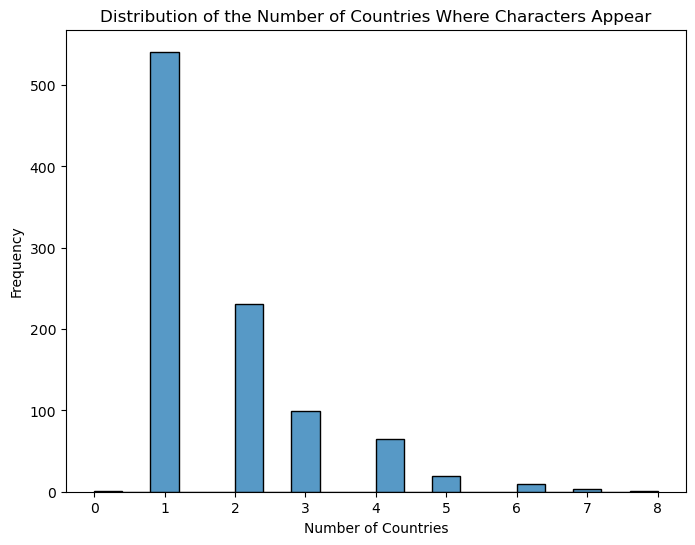

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_character_influence['number_countries'], kde=False, bins=20)

plt.title('Distribution of the Number of Countries Where Characters Appear')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.show()

In [ ]:
print(df_character_influence[df_character_influence['number_countries'] > 1].count()) #Number of characters that appear in more than one country
print("number of influence point to be given :",df_character_influence['number_countries'].sum()-970) #Number of influence point to be given

Character                      428
character_actor_freebase_id    428
actor_name                     428
first_movie_name               428
first_apperance_date           428
origin_country                 428
all_countries                  428
number_countries               428
dtype: int64
number of influence point to be given : 774


Of the 970 characters, 428 appear in movies produced across different countries, which is not a large sample. We will keep this in mind as we test the significance of our study.

For each character appearing in a movie produced by a different country, we will assign 1 influence point to the character's origin country. This results in a total of 774 points being assigned.

A major concern that remains is whether the method of taking the first movie appearance as the origin country of a character is reliable.

Let's test this with the character that appears in movies produced in the most countries.

In [ ]:
#find the character that appear in 8 countries and show all the origin countries one by one

df_character_influence[df_character_influence['number_countries'] == 8].head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
120,Cardinal Richelieu,/m/02vbtwv,Charlton Heston,The Three Musketeers,1973-01-01,"[United States of America, Spain, United Kingdom]","[Australia, Spain, Austria, Panama, United Sta...",8


The character appearing in productions from the most different countries is Cardinal Richelieu (French origin). However, with our initial method, the influence points would not have been distributed to France but to UK, US and Spain.

This analysis drives us to explore other methods for identifying character origins. One possibility is to leverage Natural Language Processing (NLP) models, such as spaCy to analyze movie summaries geographical terms and better determine the character's origin. 

Additionally, using embedding models like Hugging Face transformers could help identify implicit relationships within the movie summaries and find where the history of the movie take place and deduct the characters origin from this.

### Population

# I. Studying the international careers of actors

The goal of this part is to see whether actors tend to have more international careers. The final goal of this part is to plot a map of the world in which two countries are linked by an edge if an actor has played in those two countries. The size of the edges will depend on the number of actors.

This plot will allow us to see how the number of connections evolved and to look for the eventual emergence of clusters.

## 1. Analysis of the data on actors who have an international career

For this first analysis, we started by looking only at the single productions and excluding co-productions. 

It seems that co-productions are the initiatives of the productors and not of the actors. Therefore, they do not really reflect the movements of population associated with globalization. Indeed, if an american actor played in an americano-indian movie, it cannot really be considered as an international career. Moreover, one single co-production involves a lot of actors which might completely drawn the data from single productions.

In this process, we might loose a bit of information about actors who participated in co-production that did not include their country of origin and otherwise never performed abroad. However, the amount of co-productions in the dataset is quite small so our analysis will remain relevant.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#importing df
data_folder = '../../data/cleanData/'
df_characters = pd.read_csv(data_folder + 'characters_cleaned.csv')
df_movies = movies_df = pd.read_csv(data_folder + 'movies_cleaned.csv')

In [ ]:
# Creating a dataframe that contains only lines associated with single production movies

import sys
sys.path.append('../scripts')

import populationScripts as ps      # Import the function that processes the data for this study

df_single_prod = ps.createSingleProdDf()
df_single_prod.head()

AttributeError: module 'populationScripts' has no attribute 'createSingleProdDf'

In [ ]:
#comparison between the total number of movies and the number of co-productions
print(ps.comparisonSingleCoProd())

The number of movies resulting from co-productions is quite small, which confirms that our analysis using only single-productions is relevant

In [ ]:
# Plot showing the number of countries in which actors have played

number_countries_per_actor = ps.numberCountriesPerActor()

#let's plot the result
plt.hist(number_countries_per_actor, log=True)
plt.xlabel('number of countries per actor')
plt.ylabel('counts')
plt.title('Repartition of the number of countries per actor')
plt.show()

This plot shows that there is a significant number of actors who played in several countries. It is relevant to study them

In [ ]:
# dataframe containing only the international actors
# statistics on the number of actors and the number of countries that will be involved in our final graph

## 2. Feasibility of the graph

The final goal of this part is to plot a map of the world in which two countries are linked by an edge if an actor has played in those two countries.

To study the feasibility of this goal, we used networkx to see if the realization of a graph with our data was feasible and relevant.

In [ ]:
# first visualization as a graph

Plotting a graph seems feasible. However several steps remain before obtaining the final version :

- Our first graph includes all the years. We should separate the data per year
- Making the plot interactive 
- Using a dictionary to add the names of the countries
- Linking the countries with the ones from the geopanda library to plot the graph as a map